In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1


In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
DATA_DIR = '../input/cian-data-spb-price-prediction/'
cian_df = pd.read_csv(DATA_DIR + 'cian_data_SPB.csv')

# Preparing to ML

In [6]:
cian_df.columns

Index(['Описание', 'Адрес', 'Метро', 'Время до метро', 'Цена', 'Общая',
       'Жилая', 'Кухня', 'Этаж', 'Построен', 'Тип жилья', 'Высота потолков',
       'Тип дома', 'Тип перекрытий', 'Подъезды', 'Лифты', 'Отопление', 'Район',
       'Микрорайон', 'Улица', 'Этажей в доме', 'Количество комнат+кухня',
       'Количество совмещенных санузлов', 'Количество раздельных санузлов',
       'Количество балконов', 'Количество лоджий', 'Квартира на 1 этаже',
       'Квартира на последнем этаже', 'Город и метро', 'Широта метро',
       'Долгота метро', 'Широта адреса', 'Долгота адреса', 'До центра',
       'До метро', 'Количество преступлений в районе'],
      dtype='object')

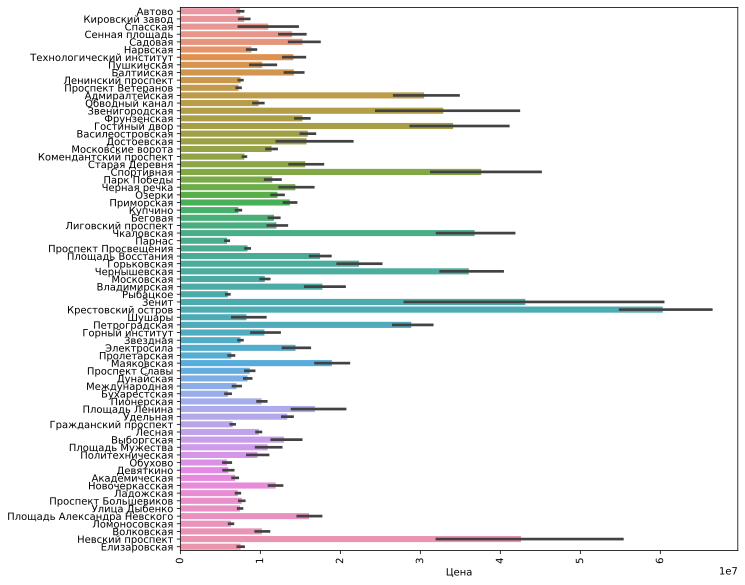

In [7]:
plt.figure(figsize=(10,10))
sns.barplot(cian_df['Цена'], cian_df['Метро'].values)
plt.xticks(rotation=90);

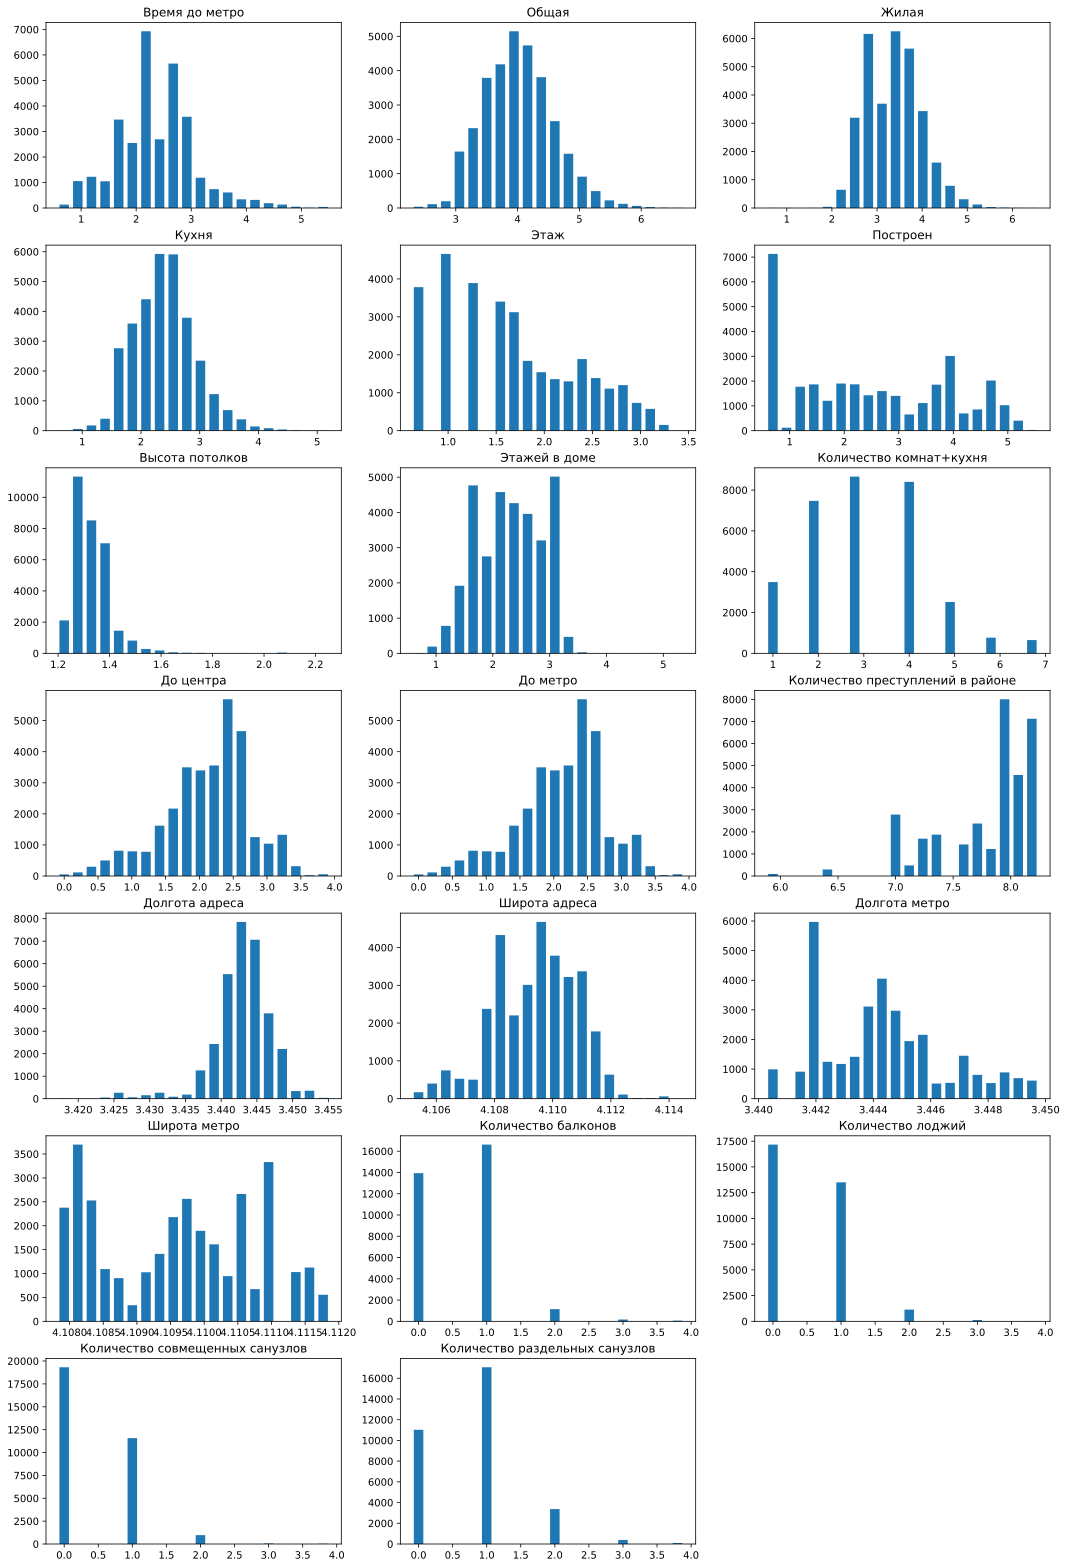

In [8]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'Время до метро': np.log(cian_df['Время до метро']+1),
    'Общая': np.log(cian_df['Общая']+1),
    'Жилая': np.log(cian_df['Жилая']+1),
    'Кухня': np.log(cian_df['Кухня']+1),
    'Этаж': np.log(cian_df['Этаж']+1),
    'Построен': np.log(2024-cian_df['Построен']),
    'Высота потолков': np.log(cian_df['Высота потолков']+1),
    'Этажей в доме': np.log(cian_df['Этажей в доме']+1),
    'Количество комнат+кухня': cian_df['Количество комнат+кухня'],
    'До центра': np.log (cian_df['До центра']+1),
    'До метро': np.log (cian_df['До центра']+1),
    'Количество преступлений в районе': np.log(cian_df['Количество преступлений в районе']+1),
    "Долгота адреса": np.log(cian_df['Долгота адреса']+1),
    "Широта адреса": np.log(cian_df['Широта адреса']+1),
    "Долгота метро": np.log(cian_df['Долгота метро']+1),
    "Широта метро": np.log(cian_df['Широта метро']+1),
    'Количество балконов': cian_df['Количество балконов'],
    'Количество лоджий': cian_df['Количество лоджий'],
    'Количество совмещенных санузлов': cian_df['Количество совмещенных санузлов'],
    'Количество раздельных санузлов': cian_df['Количество раздельных санузлов'],
    
})

In [9]:
cian_df1=cian_df.copy() 

In [10]:
#Прологарифмируем целевую переменную, чтобы распределение было более нормальным:
cian_df1['Цена'] = cian_df1['Цена'].apply(lambda x: np.log(x+1))

In [11]:
#Прологарифмируем признаки, чтобы распределение было более нормальным:
cian_df1[['Время до метро','Общая','Жилая','Кухня','Этаж','Высота потолков','Этажей в доме','До метро'
          ,'До центра','Количество преступлений в районе','Широта метро','Долгота метро'
         , 'Широта адреса','Долгота адреса']] = cian_df1[['Время до метро','Общая','Жилая','Кухня','Этаж','Высота потолков','Этажей в доме','До метро'
          ,'До центра','Количество преступлений в районе','Широта метро','Долгота метро'
         , 'Широта адреса','Долгота адреса']].apply(lambda x: np.log(x+1))
cian_df1['Построен'] = cian_df1['Построен'].apply(lambda x: np.log(2024-x))

In [12]:
cian_df1.head()

,Описание,Адрес,Метро,Время до метро,Цена,Общая,Жилая,Кухня,Этаж,Построен,...,Квартира на 1 этаже,Квартира на последнем этаже,Город и метро,Широта метро,Долгота метро,Широта адреса,Долгота адреса,До центра,До метро,Количество преступлений в районе
0,Арт. 36084264 Продаётся 2-к.квартира общей пло...,"Санкт-Петербург, р-н Кировский, Дачное, Ленинс...",Автово,2.772589,15.717618,3.899950,3.387774,2.197225,1.386294,3.583519,...,0.0,0.0,"Санкт-Петербург, метро Автово",4.108696,3.442384,4.108432,3.441941,2.451582,1.082170,7.991592
1,Арт. 43292484 Продаётся 4 комнатная коммунальн...,"Санкт-Петербург, р-н Кировский, Автово, просп....",Автово,1.791759,16.204273,4.739701,4.394449,2.397895,1.791759,4.219508,...,0.0,0.0,"Санкт-Петербург, метро Автово",4.108696,3.442384,4.108731,3.442316,2.256333,0.234068,7.991592
2,Арт. 43572482 В продаже просторная трёхкомнатн...,"Санкт-Петербург, р-н Кировский, Автово, просп....",Автово,2.197225,16.454568,4.644391,4.166665,3.044522,1.386294,4.248495,...,0.0,0.0,"Санкт-Петербург, метро Автово",4.108696,3.442384,4.108784,3.442237,2.233289,0.502241,7.991592
3,Арт. 35008138 Предлагается к продаже просторна...,"Санкт-Петербург, р-н Кировский, Автово, просп....",Кировский завод,2.079442,16.001562,4.471296,4.060443,2.397895,0.693147,4.219508,...,1.0,0.0,"Санкт-Петербург, метро Кировский завод",4.108899,3.442402,4.108859,3.442257,2.186858,0.314154,7.991592
4,"Студия в историческом центре города, 5 минуты ...","Санкт-Петербург, р-н Адмиралтейский, Сенной, Г...",Спасская,1.609438,14.731802,2.708050,2.167224,1.277591,1.098612,5.384495,...,0.0,0.0,"Санкт-Петербург, метро Спасская",4.109674,3.444231,4.109677,3.444378,0.864857,0.230610,7.707512


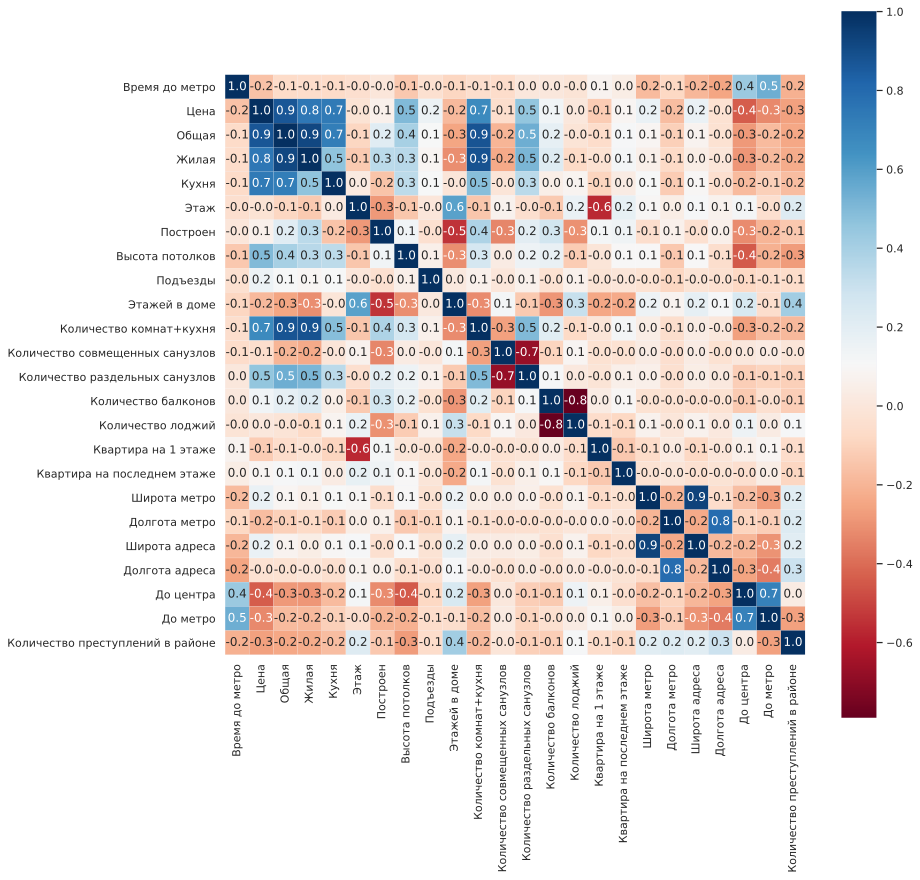

In [13]:
#Построим  корреляционную матрицу:
sns.set(font_scale=1)
plt.subplots(figsize=(13, 13))
sns.heatmap(cian_df1.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

# ML: Catboost Regresssor

In [14]:
#Удалим целевую переменную и признак 'Жилая' из-за мультиколлинеарности:
X = cian_df1.drop(['Цена','Жилая'], axis=1)  
y = cian_df1.Цена

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [16]:
X_train = pd.get_dummies(X_train, columns = ['Метро', 'Тип жилья', 'Тип дома',
                                               'Тип перекрытий','Лифты', 'Отопление', 'Район'], dummy_na=True)
X_test = pd.get_dummies(X_test, columns = ['Метро', 'Тип жилья', 'Тип дома',
                                               'Тип перекрытий','Лифты', 'Отопление', 'Район'], dummy_na=True)

In [17]:
X_train = X_train.drop(['Описание','Адрес','Улица','Микрорайон','Город и метро'],axis=1)
X_test = X_test.drop(['Описание','Адрес','Улица','Микрорайон','Город и метро'],axis=1)  

In [18]:
#Нормализуем наши данные:
scaler = MinMaxScaler()
X_train_norm=scaler.fit_transform(X_train)
X_test_norm=scaler.transform(X_test)

In [19]:
model = CatBoostRegressor(iterations = 1500,
                          learning_rate = 0.03,
                          random_seed = 42,
                          depth=10,
                          #l2_leaf_reg=3,
                          #bagging_temperature=1,
                          #random_strength=1,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train_norm, y_train,
         eval_set=(X_test_norm, y_test),
         verbose_eval=200,
         use_best_model=True,
         plot=True
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0326780	test: 0.0329448	best: 0.0329448 (0)	total: 137ms	remaining: 3m 26s
200:	learn: 0.0077414	test: 0.0083834	best: 0.0083834 (200)	total: 12.1s	remaining: 1m 18s
400:	learn: 0.0066947	test: 0.0076239	best: 0.0076239 (400)	total: 23.5s	remaining: 1m 4s
600:	learn: 0.0060267	test: 0.0071870	best: 0.0071870 (600)	total: 35.9s	remaining: 53.6s
800:	learn: 0.0055295	test: 0.0069205	best: 0.0069205 (800)	total: 48.1s	remaining: 42s
1000:	learn: 0.0051460	test: 0.0067582	best: 0.0067582 (1000)	total: 1m 1s	remaining: 30.7s
1200:	learn: 0.0048305	test: 0.0066393	best: 0.0066393 (1200)	total: 1m 14s	remaining: 18.5s
1400:	learn: 0.0045573	test: 0.0065462	best: 0.0065462 (1400)	total: 1m 26s	remaining: 6.14s
1499:	learn: 0.0044312	test: 0.0065031	best: 0.0065031 (1499)	total: 1m 33s	remaining: 0us

bestTest = 0.006503075642
bestIteration = 1499



In [20]:
test_predict_catboost=model.predict(X_test_norm)

In [21]:
np.exp(test_predict_catboost)

array([ 6394332.48850502, 13612256.45866017,  5450347.56389612, ...,
        6329212.75162374,  8002067.0266276 ,  6738809.13195358])

In [22]:
np.exp(y_test)

16697     6070001.0
12281    13041547.0
29769     5500001.0
7558      5599001.0
16328     4290001.0
            ...    
16908     5900001.0
12639    11620001.0
17361     6670001.0
1383      7500001.0
13271     7540001.0
Name: Цена, Length: 7988, dtype: float64

In [23]:
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 10.63%


In [24]:
#За 1000 итераций и 1 минуту обучения MAPE = 11,03% !
#За 1500 итераций и 1 минуту 24 секунды обучения MAPE = 10,63% !
#За 6000 итераций и 7 минут 43 секунды обучения MAPE = 9,68% !

# DL: Tabular NN

In [25]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
cian_df2 = pd.get_dummies(cian_df1, columns = ['Метро', 'Тип жилья', 'Тип дома',
                                               'Тип перекрытий','Лифты', 'Отопление', 'Район'
                                   ,'Микрорайон','Улица'], dummy_na=True)

In [27]:
#Удалим целевую переменную и признак 'Жилая' из-за мультиколлинеарности:
X1 = cian_df2.drop(['Цена','Жилая'], axis=1)  
y1 = cian_df2.Цена

In [28]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [29]:
X_train1 = X_train1.drop(['Описание','Адрес','Город и метро'],axis=1)
X_test1 = X_test1.drop(['Описание','Адрес','Город и метро'],axis=1)  

In [30]:
#Нормализуем наши данные:
scaler = MinMaxScaler()
X_train_norm1=scaler.fit_transform(X_train1)
X_test_norm1=scaler.transform(X_test1)

In [31]:
X_train_norm1.shape[1]

1490

In [32]:
X_test_norm1.shape[1]

1490

In [33]:
#tf.keras.backend.clear_session()

In [34]:
model_nn = Sequential()
model_nn.add(L.Dense(2048, input_dim=X_train_norm1.shape[1], activation="relu")) #1024
model_nn.add(L.Dropout(0.7)) #0.75
model_nn.add(L.Dense(1024, activation="relu")) #512
model_nn.add(L.Dropout(0.6)) #0.6
model_nn.add(L.Dense(1, activation="linear"))

In [35]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              3053568   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 5,152,769
Trainable params: 5,152,769
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model_nn.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [37]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [38]:
#Возвратим целевые переменные в исходный вид
y_train1=np.exp(y_train)
y_test1=np.exp(y_test)

In [39]:
history = model_nn.fit(X_train_norm1, y_train1,
                    batch_size=512, #512
                    epochs=200, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test_norm1, y_test1),
                    verbose=0,
                   )

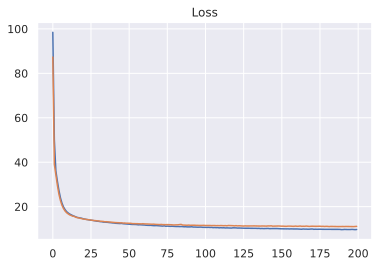

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
test_predict_nn = model_nn.predict(X_test_norm1)

In [42]:
test_predict_nn

array([[ 7026709. ],
       [13273814. ],
       [ 5381328. ],
       ...,
       [ 5987296. ],
       [ 7973450. ],
       [ 6685655.5]], dtype=float32)

In [43]:
y_test1

16697     6070001.0
12281    13041547.0
29769     5500001.0
7558      5599001.0
16328     4290001.0
            ...    
16908     5900001.0
12639    11620001.0
17361     6670001.0
1383      7500001.0
13271     7540001.0
Name: Цена, Length: 7988, dtype: float64

In [44]:
test_predict_nn[0]

array([7026709.], dtype=float32)

In [45]:
test_predict_nn1=[test_predict_nn[i][0] for i in range (len(test_predict_nn))]

In [46]:
print(f"TEST mape: {(mape(y_test1, test_predict_nn1))*100:0.2f}%")

TEST mape: 11.13%


In [47]:
#mape=11.86 на 500 итерациях за 1 мин 40 сек (cian_df)
#mape=11.01 на 500 итерациях за 1 мин 40 сек (cian_df1)
#mape=11.01 на 500 итерациях за 1 мин 40 сек (cian_df1)
#mape=11.03 на 350 итерациях за 1 мин (cian_df1)

In [48]:
np.exp(test_predict_catboost)

array([ 6394332.48850502, 13612256.45866017,  5450347.56389612, ...,
        6329212.75162374,  8002067.0266276 ,  6738809.13195358])

In [49]:
blend_sub=(test_predict_nn1+np.exp(test_predict_catboost))/2

In [50]:
blend_sub

array([ 6710520.74425251, 13443035.22933008,  5415837.78194806, ...,
        6158254.37581187,  7987758.5133138 ,  6712232.31597679])

In [51]:
# 1 мин catboost (1000итер - 11,04%) + 1мин 40 сек nn(500 итер - 11,01%) = 10.35%
# 1 мин 24 сек catboost (1500итер - 10,63%) + 1мин 40 сек nn(500 итер - 11,01%) = 10.17%
# 1 мин 24 сек catboost (1500итер - 10,63%) + 1мин nn(350 итер - 11,03%) = 10.19%
# 1 мин 24 сек catboost (1500итер - 10,63%) + 40 сек nn(200 итер - 11,25%) = 10.24%
# 1 мин catboost (1000итер - 11,04%) + 40 сек nn(200 итер - 11,25%) = 10.47%
# 2 мин catboost (2000итер - 10,35%) + 1мин nn(350 итер - 11,03%) = 10.07%
# 2 мин 30 cек catboost (2500итер - 10,17%) + 40 сек nn(200 итер - 11,25%) = 10.04%
# 1 мин 24 сек catboost (1500итер - 10,63%) + 43 сек nn(200 итер - 11,10%) = 10.2%   

In [52]:
print(f"TEST mape: {(mape(y_test1, np.floor(blend_sub/10000)*10000))*100:0.2f}%")

TEST mape: 10.14%


### ИТОГ: итоговая модель - blend из catboostregressor(1500 iterations) + nn(200 iterations). Время обработки моделей: 2 мин 10 сек. 